In [1]:
import numpy as np
import FactorBP as FB
import scipy.io as sio
import matlab.engine
import time
eng = matlab.engine.start_matlab()

In [3]:
def ComputeAccurancy(Decode, gTruth, NofInliers):
    Ccnt = 0
    for i in range(NofInliers):
        if(Decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers

def LoadHouse():
    res = np.zeros([111, 30, 2])
    for i in range(1,112):
        res[i-1] = np.loadtxt('data/cmum/house/label/house%d' %i)
    return res
HouseData = LoadHouse()
NofAlgorithms = 8
AlgorithmNames=['Ours', 'Ours-BCA', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
start = 0
end = 111
MeanAcc = np.zeros([10,NofAlgorithms])
MeanRtime = np.zeros([10, NofAlgorithms])
MeanObj = np.zeros([10, NofAlgorithms])
AllAcc = {}
AllRtim = {}
AllObj = {}
for baseline in xrange(10,101,10):
    print(' Start baseline: %d' % (baseline))
    AllAcc[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    AllRtim[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    # AllObj[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    Obj = np.zeros([NofAlgorithms, end - baseline])

    for ImageI in range(start, end - baseline):
        PT1 = np.copy(HouseData[ImageI])
        PT2 = np.copy(HouseData[ImageI+baseline])
        NofNodes = 30
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        PF1 = np.zeros([NofNodes,1])
        PF2 = np.zeros([NofNodes,2])
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])

        [G, FName] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, False)
        # G2 = FB.ConstructMatchingModel(MG1, MG2, 'cmu', False, True)
        [Gvis, FName] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, False)
        G.SetVerbose(False)

        # Our results 1
        res1 = FB.BaBSolver(G, 30, 10, 0.005, False)
        AllAcc[(baseline-10)/10][0][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
        AllRtim[(baseline-10)/10][0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value
        #end Our results 1
        
        # BCA
        resBag = eng.runBcagm(FName, nargout=3)
        AllAcc[(baseline-10)/10][2][ImageI] = ComputeAccurancy(resBag[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][2][ImageI] = resBag[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resBag[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA
        
        # BCA-MP
        resBagMP = eng.runBcagmQuad1(FName, 1,nargout=3)
        AllAcc[(baseline-10)/10][3][ImageI] = ComputeAccurancy(resBagMP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][3][ImageI] = resBagMP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagMP[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA-MP
        
        # BCA-IPFP
        resBagIPFP = eng.runBcagmQuad1(FName, 2,nargout=3)
        AllAcc[(baseline-10)/10][4][ImageI] = ComputeAccurancy(resBagIPFP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][4][ImageI] = resBagIPFP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagIPFP[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA-IPFP
        
        # HGM
        resHGM = eng.runHGM(FName, nargout=3)
        AllAcc[(baseline-10)/10][5][ImageI] = ComputeAccurancy(resHGM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][5][ImageI] = resHGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resHGM[1][0][i])
        Obj[5][ImageI] = Gvis.ComputeObj(cDecode)
        #end HGM
        
        # RRWHM
        resRRWHM = eng.runRRWHM(FName, nargout=3)
        #resRRWHM = eng.runBcagm(nargout=3)
        AllAcc[(baseline-10)/10][6][ImageI] = ComputeAccurancy(resRRWHM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][6][ImageI] = resRRWHM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWHM[1][0][i])
        Obj[6][ImageI] = Gvis.ComputeObj(cDecode)
        #end RRWHM
        
        # TensorMatching
        resTM = eng.runTensorMatching(FName, nargout=3)
        AllAcc[(baseline-10)/10][7][ImageI] = ComputeAccurancy(resTM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][7][ImageI] = resTM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resTM[1][0][i])
        Obj[7][ImageI] = Gvis.ComputeObj(cDecode)
        #end TensorMatching
        
        # Our-BCA Results
        start_time = time.time()
        ResForBca = sio.loadmat(FName)
        X0 = np.zeros(NofNodes)
        X0Vec = res1.Decode
        for i in xrange(NofNodes):
            X0[i] = X0Vec[i]
        ResForBca['X0'] = X0
        sio.savemat(FName, ResForBca)
        resOursBCA = eng.runBcagm(FName, nargout=3)
        time_dur = time.time() - start_time

        cDecode = FB.intArray(NofNodes)
        #print(resOursBCA[1][0])
        for i in range(NofNodes):
            cDecode[i] = int(resOursBCA[1][0][i])
        if res1.Value < Gvis.ComputeObj(cDecode): #??? Lee
            AllAcc[(baseline-10)/10][1][ImageI] = ComputeAccurancy(resOursBCA[1][0], gTruth, NofNodes)
            Obj[1][ImageI] = Gvis.ComputeObj(cDecode)
        else:
            AllAcc[(baseline-10)/10][1][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
            Obj[1][ImageI] = res1.Value
        AllRtim[(baseline-10)/10][1][ImageI] = time_dur + res1.Time
        #end Our-BCA Results
        
        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj
        AllObj[(baseline-10)/10] = Obj
        #for ai in xrange(NofAlgorithms):
        #    print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
        #                                                     AllAcc[(baseline-10)/10][ai][ImageI],
        #                                                    AllRtim[(baseline-10)/10][ai][ImageI],
        #                                                   AllObj[(baseline-10)/10][ai][ImageI]))
        #print(' Finished Frame: %d ----------------------' % (ImageI) )
        #end inner loop
    for ai in xrange(NofAlgorithms):
        MeanAcc[(baseline-10)/10][ai] = np.mean(AllAcc[(baseline-10)/10][ai])
        MeanRtime[(baseline-10)/10][ai] = np.mean(AllRtim[(baseline-10)/10][ai])
        # MeanObj[(baseline-10)/10][ai] = np.mean(Obj[ai])
        MeanObj[(baseline-10)/10][ai] = np.mean(AllObj[(baseline-10)/10][ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        MeanAcc[(baseline-10)/10][ai],
                                                        MeanRtime[(baseline-10)/10][ai],
                                                        MeanObj[(baseline-10)/10][ai]))
    print('××××××××××××××××××××')
    #end outer loop

 Start baseline: 10


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.011817 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.036826 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.017509 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.092393 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.074296 Obj 1.000000
HGM Accuracy 0.708581 Running Time 0.003452 Obj 0.706385
RRWHM Accuracy 1.000000 Running Time 0.041652 Obj 1.000000
TM Accuracy 0.783498 Running Time 0.060466 Obj 0.830221
××××××××××××××××××××
 Start baseline: 20


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.038684 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.066322 Obj 1.000000
BCA Accuracy 0.998901 Running Time 0.019634 Obj 0.999891
BCA-MP Accuracy 1.000000 Running Time 0.109573 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.082211 Obj 1.000000
HGM Accuracy 0.602198 Running Time 0.003844 Obj 0.636318
RRWHM Accuracy 1.000000 Running Time 0.048895 Obj 1.000000
TM Accuracy 0.668864 Running Time 0.067076 Obj 0.772487
××××××××××××××××××××
 Start baseline: 30


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 0.998765 Running Time 0.110604 Obj 0.999818
Ours-BCA Accuracy 1.000000 Running Time 0.138600 Obj 1.000000
BCA Accuracy 0.990535 Running Time 0.020204 Obj 0.999195
BCA-MP Accuracy 0.997942 Running Time 0.114289 Obj 0.999789
BCA-IPFP Accuracy 0.999177 Running Time 0.085518 Obj 0.999960
HGM Accuracy 0.489300 Running Time 0.003901 Obj 0.565696
RRWHM Accuracy 0.998354 Running Time 0.066426 Obj 0.999987
TM Accuracy 0.540741 Running Time 0.069562 Obj 0.712263
××××××××××××××××××××
 Start baseline: 40


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 0.998122 Running Time 0.212556 Obj 0.999958
Ours-BCA Accuracy 0.998122 Running Time 0.240500 Obj 0.999958
BCA Accuracy 0.974648 Running Time 0.020923 Obj 0.995698
BCA-MP Accuracy 0.992958 Running Time 0.125851 Obj 0.998876
BCA-IPFP Accuracy 0.986385 Running Time 0.098646 Obj 0.998321
HGM Accuracy 0.392958 Running Time 0.003897 Obj 0.544965
RRWHM Accuracy 0.978873 Running Time 0.093814 Obj 0.996820
TM Accuracy 0.403286 Running Time 0.070756 Obj 0.666320
××××××××××××××××××××
 Start baseline: 50


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 0.995628 Running Time 0.307320 Obj 0.999595
Ours-BCA Accuracy 0.993443 Running Time 0.336079 Obj 0.999902
BCA Accuracy 0.932240 Running Time 0.021816 Obj 0.988592
BCA-MP Accuracy 0.989071 Running Time 0.144526 Obj 0.998998
BCA-IPFP Accuracy 0.965027 Running Time 0.100627 Obj 0.993057
HGM Accuracy 0.310929 Running Time 0.003890 Obj 0.539428
RRWHM Accuracy 0.962295 Running Time 0.124963 Obj 0.995146
TM Accuracy 0.298361 Running Time 0.071186 Obj 0.647881
××××××××××××××××××××
 Start baseline: 60


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 0.947059 Running Time 0.365221 Obj 0.993909
Ours-BCA Accuracy 0.950327 Running Time 0.394353 Obj 0.995475
BCA Accuracy 0.824837 Running Time 0.022959 Obj 0.967144
BCA-MP Accuracy 0.947059 Running Time 0.170080 Obj 0.996085
BCA-IPFP Accuracy 0.892810 Running Time 0.116686 Obj 0.984145
HGM Accuracy 0.267320 Running Time 0.003858 Obj 0.547329
RRWHM Accuracy 0.854248 Running Time 0.185711 Obj 0.981452
TM Accuracy 0.234641 Running Time 0.069725 Obj 0.654217
××××××××××××××××××××
 Start baseline: 70


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 0.873984 Running Time 0.416518 Obj 0.982583
Ours-BCA Accuracy 0.882114 Running Time 0.445843 Obj 0.996895
BCA Accuracy 0.719512 Running Time 0.023546 Obj 0.952249
BCA-MP Accuracy 0.885366 Running Time 0.183640 Obj 0.990653
BCA-IPFP Accuracy 0.809756 Running Time 0.135614 Obj 0.975545
HGM Accuracy 0.250407 Running Time 0.003828 Obj 0.563354
RRWHM Accuracy 0.767480 Running Time 0.234117 Obj 0.978081
TM Accuracy 0.282927 Running Time 0.071235 Obj 0.693181
××××××××××××××××××××
 Start baseline: 80


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 0.729032 Running Time 0.413149 Obj 0.960992
Ours-BCA Accuracy 0.746237 Running Time 0.442524 Obj 0.987133
BCA Accuracy 0.612903 Running Time 0.023011 Obj 0.953417
BCA-MP Accuracy 0.788172 Running Time 0.257625 Obj 0.981703
BCA-IPFP Accuracy 0.730108 Running Time 0.162536 Obj 0.975570
HGM Accuracy 0.224731 Running Time 0.003919 Obj 0.577967
RRWHM Accuracy 0.633333 Running Time 0.254527 Obj 0.957580
TM Accuracy 0.272043 Running Time 0.069055 Obj 0.721420
××××××××××××××××××××
 Start baseline: 90


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 0.595238 Running Time 0.395434 Obj 0.962104
Ours-BCA Accuracy 0.600000 Running Time 0.424020 Obj 0.988621
BCA Accuracy 0.530159 Running Time 0.024492 Obj 0.945636
BCA-MP Accuracy 0.622222 Running Time 0.296621 Obj 0.980756
BCA-IPFP Accuracy 0.600000 Running Time 0.158576 Obj 0.965557
HGM Accuracy 0.190476 Running Time 0.004287 Obj 0.588267
RRWHM Accuracy 0.558730 Running Time 0.245256 Obj 0.965766
TM Accuracy 0.192063 Running Time 0.074294 Obj 0.704531
××××××××××××××××××××
 Start baseline: 100


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 0.566667 Running Time 0.420817 Obj 0.972355
Ours-BCA Accuracy 0.566667 Running Time 0.451678 Obj 0.993179
BCA Accuracy 0.412121 Running Time 0.022593 Obj 0.950703
BCA-MP Accuracy 0.466667 Running Time 0.302727 Obj 0.970608
BCA-IPFP Accuracy 0.475758 Running Time 0.172393 Obj 0.960709
HGM Accuracy 0.148485 Running Time 0.003533 Obj 0.594123
RRWHM Accuracy 0.487879 Running Time 0.333085 Obj 0.974057
TM Accuracy 0.142424 Running Time 0.066780 Obj 0.667465
××××××××××××××××××××


array([ 1.        ,  1.        ,  0.99876543,  0.99812207,  0.99562842,
        0.94705882,  0.87398374,  0.72903226,  0.5952381 ,  0.56666667])

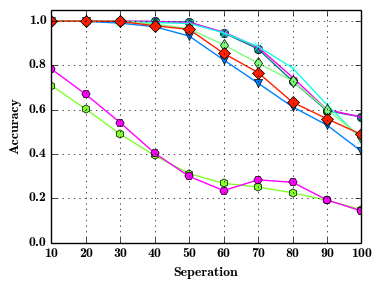

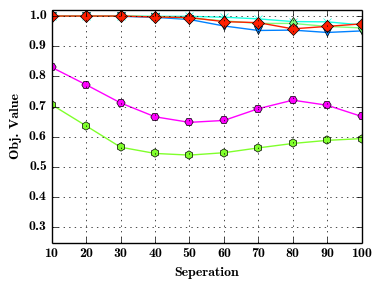

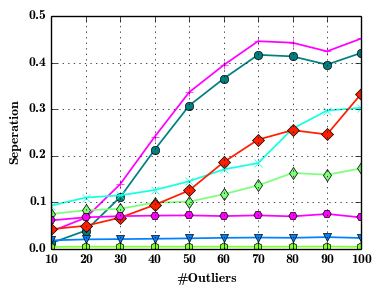

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
%matplotlib inline


Colors = [[ 0.        ,  0.5       , 0.5        ,  1.        ],
          [ 1.        ,  0.00196078,  1.        ,  1.        ],
          [ 0.        ,  0.50392157,  1.        ,  1.        ],
          [ 0.08538899,  1.        ,  0.88235294,  1.        ],
          [ 0.49019608,  1.        ,  0.47754586,  1.        ],
          [ 0.5       ,  1.        ,  0.17273877,  1.        ],
          #[ 1.        ,  0.58169935,  0.        ,  1.        ],
          [ 1.        ,  0.11692084,  0.        ,  1.        ],
          [ 1.        ,  0.        ,  1.        ,  1.        ]]
Seq = [0, 1, 2, 3, 4, 5, 6, 7]
AlgorithmNames=['Ours', 'Ours-BCA', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
Markers = ['o', '+', 'v', 'x', 'd', 'h', 'D', 'H']

figData = pylab.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
ax = pylab.gca()

matplotlib.rc('font',family='Times New Roman')


#plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    pylab.plot(range(10,101,10), MeanAcc[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
pylab.ylim([0,1.05])
pylab.grid(True)

pylab.ylabel('Accuracy')
pylab.xlabel('Seperation')


figLegend = pylab.figure(figsize = (11.7,0.4))
pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper center',  ncol=9, shadow=True, fancybox=True)
figData.savefig('results/TripletsOnly/House_Acc.pdf')
#figLegend.savefig("legend.pdf")
figLegend.show()

#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=9)
#plt.savefig('House_ACC.pdf')    # <-- loses transparency

StoreForPlot ={}
StoreForPlot['Accuracy'] = MeanAcc
StoreForPlot['Time'] = MeanRtime
StoreForPlot['Obj'] = MeanObj

sio.savemat('results/TripletsOnly/PlotData.mat', StoreForPlot)

plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    if(AlgorithmNames[Seq[ai]] == 'Ours')|(AlgorithmNames[Seq[ai]] == 'Ours-BCA'):
        continue
    plt.plot(range(10,101,10), MeanObj[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
plt.ylim([0.25,1.02])
plt.ylabel('Obj. Value')
plt.xlabel('Seperation')
plt.grid(True)
plt.savefig('results/TripletsOnly/House_Obj.pdf')    # <-- loses transparency


plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanRtime[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)

plt.ylabel('Seperation')
plt.xlabel('#Outliers')

plt.grid(True)
plt.savefig('results/TripletsOnly/Car_Time.pdf')    # <-- loses transparency

MeanAcc[:,0]

In [16]:
PT1 = np.copy(HouseData[ImageI])
PT2 = np.copy(HouseData[ImageI+baseline])
NofNodes = 30
gTruth = np.random.permutation(NofNodes)
PT1 = PT1[gTruth, :]
PF1 = np.zeros([NofNodes,1])
PF2 = np.zeros([NofNodes,2])
MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])
G = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, False)
res1 = FB.BaBSolver(G, 30, 10, 0.005, True)

BaBIter=1, GUB = 100000000000000000000.000000, GLB = -100000000000000000000.000000, Gap = 2.00, Time=0.0027
